## Import Libraries

In [1]:
# Basic imports
import cv2
import numpy as np
import matplotlib.pyplot as plt


## Helper Function to Display Images

In [2]:
def show_image(img, title="Image"):
    """Helper function to display images inline in Jupyter Notebook."""
    plt.figure(figsize=(10,6))
    if len(img.shape) == 2:  # grayscale
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


## Preprocessing (Grayscale + Gaussian Blur + Canny)

In [3]:
def preprocess_image(img):
    """Convert to grayscale, blur, and detect edges."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, 50, 150)
    return edges


## Define Region of Interest (ROI)

In [4]:
def region_of_interest(img):
    """Mask the image to focus on the road lane region."""
    height, width = img.shape
    mask = np.zeros_like(img)

    # Define triangular region for road (tweak for your camera view)
    polygon = np.array([[
        (int(0.1*width), height),
        (int(0.9*width), height),
        (int(0.5*width), int(0.6*height))
    ]], np.int32)

    cv2.fillPoly(mask, polygon, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked


## Detect Lines using Hough Transform

In [5]:
def detect_lines(img):
    """Detect lines using Hough Transform."""
    lines = cv2.HoughLinesP(
        img,
        rho=2,
        theta=np.pi/180,
        threshold=50,
        minLineLength=40,
        maxLineGap=100
    )
    return lines


## Average & Draw Lane Lines

In [11]:
def average_slope_intercept(img, lines):
    left_lines = []
    right_lines = []

    if lines is None:
        return None, None

    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        if x2 == x1:  # vertical line → skip
            continue
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        if slope < -0.5:  # left lane
            left_lines.append((slope, intercept))
        elif slope > 0.5:  # right lane
            right_lines.append((slope, intercept))

    left_line = np.mean(left_lines, axis=0) if len(left_lines) > 0 else None
    right_line = np.mean(right_lines, axis=0) if len(right_lines) > 0 else None

    def make_points(slope, intercept):
        if slope == 0 or slope == np.inf or slope == -np.inf:
            return None
        y1 = img.shape[0]
        y2 = int(y1 * 0.6)
        try:
            x1 = int((y1 - intercept) / slope)
            x2 = int((y2 - intercept) / slope)
            return np.array([x1, y1, x2, y2])
        except:
            return None

    left_points = make_points(*left_line) if left_line is not None else None
    right_points = make_points(*right_line) if right_line is not None else None

    return left_points, right_points



def draw_lines(img, lines, color=(0,255,0), thickness=10):
    line_img = np.zeros_like(img)
    if lines[0] is not None:
        cv2.line(line_img, tuple(lines[0][:2]), tuple(lines[0][2:]), color, thickness)
    if lines[1] is not None:
        cv2.line(line_img, tuple(lines[1][:2]), tuple(lines[1][2:]), color, thickness)
    return cv2.addWeighted(img, 0.8, line_img, 1, 1)


## Full Pipeline Function

In [12]:
def process_frame(frame):
    edges = preprocess_image(frame)
    roi = region_of_interest(edges)
    lines = detect_lines(roi)
    left, right = average_slope_intercept(frame, lines)
    result = draw_lines(frame, (left, right))
    return result


## Test on a Sample Image

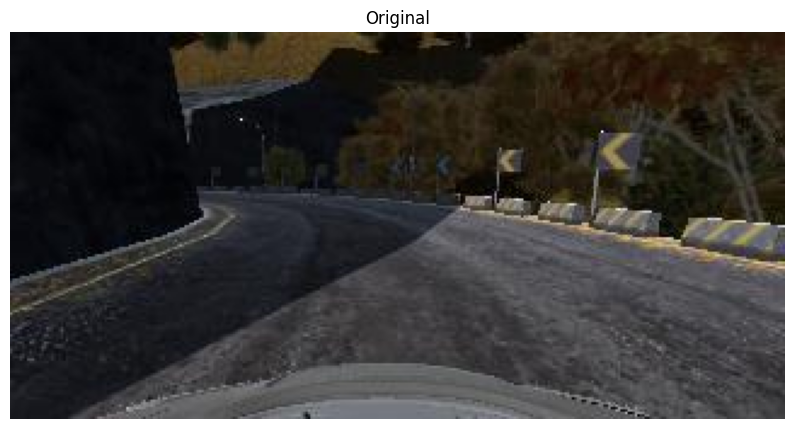

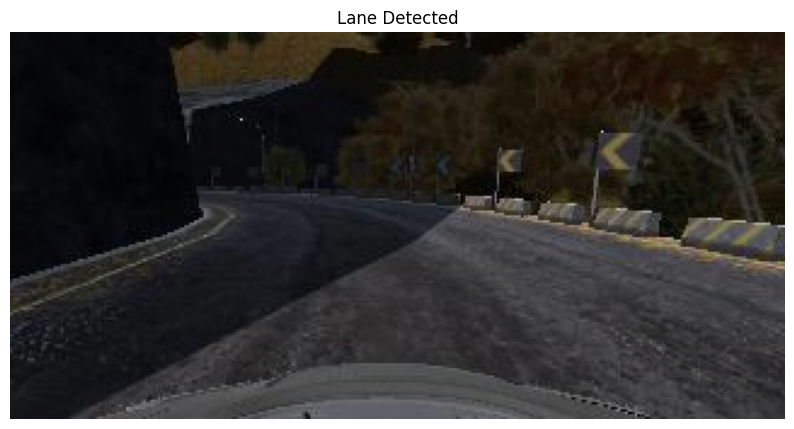

In [13]:
# Load sample road image
img = cv2.imread("C:\\Users\\nages\\AutonomousEV\\SteeringAngle\\session4\\IMG\\center_2025_08_28_12_08_11_401.jpg")
  # <-- replace with your image path
output = process_frame(img)

show_image(img, "Original")
show_image(output, "Lane Detected")


## Test on a Video

In [14]:
cap = cv2.VideoCapture("test_video.mp4")  # <-- replace with your lane video

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    result = process_frame(frame)
    cv2.imshow("Lane Detection", result)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
# Initialize webcam (0 means default webcam)
cap = cv2.VideoCapture(0)

print("Press 'q' to quit")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame for faster processing (optional)
    frame = cv2.resize(frame, (640, 480))

    # Process frame through lane detection pipeline
    result = process_frame(frame)

    # Show original and processed output side by side
    combined = np.hstack((frame, result))
    cv2.imshow("Lane Detection - Webcam", combined)

    # Press q to quit
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


Press 'q' to quit
